In [3]:
import numpy as np 
import os


data_path = './data'
actions = np.array(['smoke', 'break'])
videos = [f'video{n}' for n in range(1,13)]
no_sequence = 10  # Number of sequences
sequence_length = 30  # Length of each sequence

In [4]:
label_map = {label:num for num, label in enumerate(actions)}

sequences, labels = [], []

for action in actions:
    for video_name in videos:
        for sequence in range(no_sequence):
            window=[]
            for frame_num in range(sequence_length):
                res = np.load(os.path.join(data_path, action, video_name, f's{sequence}', "{}.npy".format(frame_num)))
                
                window.append(res)
            sequences.append(window)
            labels.append(label_map[action])

In [5]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

X = np.array(sequences)
y = to_categorical(labels, num_classes=len(actions)).astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

X.shape # (sequence data num, time step, features)

2024-06-14 11:28:24.736920: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-14 11:28:24.839487: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda-12.1/lib64
2024-06-14 11:28:24.839507: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-06-14 11:28:24.859596: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-14 11:28:25.37

(240, 30, 66)

In [7]:
X_test[8]

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.39017931, 0.85457551, 0.39234081, ..., 0.71860588, 0.30709237,
        0.80953157],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.39413664, 0.8520236 , 0.39554924, ..., 0.73054761, 0.31544793,
        0.80886602],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [22]:
import os
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import layers, Sequential


log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

model = Sequential([
    layers.LSTM(60, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    layers.Dropout(0.25),
    layers.LSTM(120, return_sequences=True, activation='relu'),
    layers.LSTM(60, return_sequences=True, activation='relu'),
    layers.Dense(60, activation='relu'),
    layers.Bidirectional(layers.LSTM(100)),
    layers.Dropout(0.25),
    layers.Dense(2, activation='softmax')
])

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 30, 60)            30480     
                                                                 
 dropout_4 (Dropout)         (None, 30, 60)            0         
                                                                 
 lstm_9 (LSTM)               (None, 30, 120)           86880     
                                                                 
 lstm_10 (LSTM)              (None, 30, 60)            43440     
                                                                 
 dense_4 (Dense)             (None, 30, 60)            3660      
                                                                 
 bidirectional_2 (Bidirectio  (None, 200)              128800    
 nal)                                                            
                                                      

In [23]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])


# (선택 사항) 즉시 실행 모드 설정
tf.config.experimental_run_functions_eagerly(True)

# 모델 학습
history = model.fit(X_train, y_train, epochs=100, callbacks=[tb_callback, early_stopping], validation_split=0.2)


# 모델 요약
model.summary()


Epoch 1/100
6/6 [==============================] - 4s 675ms/step - loss: 0.6677 - categorical_accuracy: 0.4945 - val_loss: 0.6886 - val_categorical_accuracy: 0.5870
Epoch 2/100
6/6 [==============================] - 5s 941ms/step - loss: 0.6272 - categorical_accuracy: 0.7473 - val_loss: 0.6579 - val_categorical_accuracy: 0.7174
Epoch 3/100
6/6 [==============================] - 5s 861ms/step - loss: 0.5680 - categorical_accuracy: 0.7857 - val_loss: 0.6061 - val_categorical_accuracy: 0.6087
Epoch 4/100
6/6 [==============================] - 5s 1s/step - loss: 0.5178 - categorical_accuracy: 0.7747 - val_loss: 0.5884 - val_categorical_accuracy: 0.7826
Epoch 5/100
6/6 [==============================] - 5s 832ms/step - loss: 0.4344 - categorical_accuracy: 0.7692 - val_loss: 0.5396 - val_categorical_accuracy: 0.8043
Epoch 6/100
6/6 [==============================] - 7s 1s/step - loss: 0.4557 - categorical_accuracy: 0.8077 - val_loss: 0.5229 - val_categorical_accuracy: 0.7826
Epoch 7/100
6/6 

1/1 [==============================] - 0s 280ms/step
Test Accuracy: 0.6666666666666666


/home/jinsa/venv/DL_project_venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 452ms/step - loss: 0.5841 - categorical_accuracy: 0.6667
Test Loss: 0.5841053128242493
Test Accuracy: 0.6666666865348816


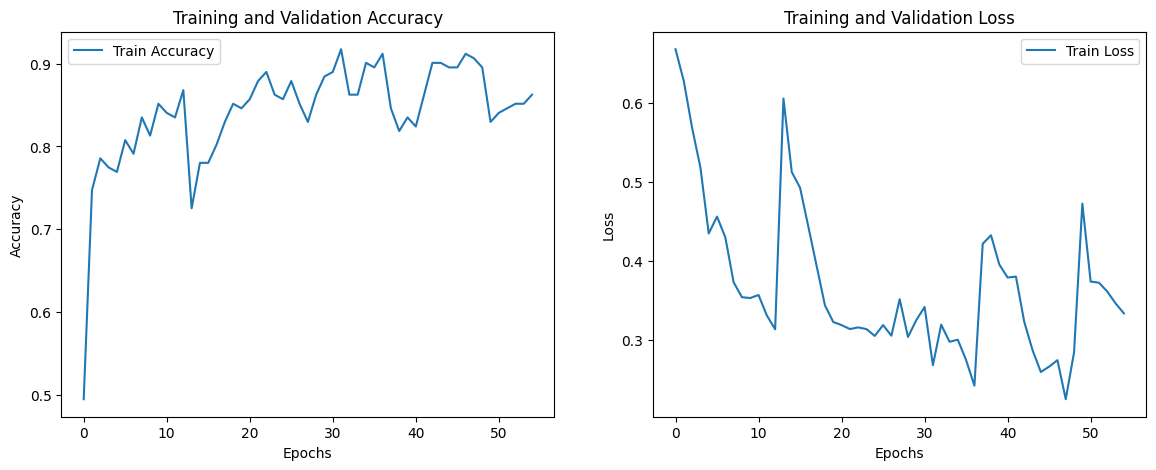

In [24]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score

res = model.predict(X_test)


y_pred = np.argmax(res, axis=1)
y_true = np.argmax(y_test, axis=1)


test_accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {test_accuracy}")


test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")


def plot_history(history):
    
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['categorical_accuracy'], label='Train Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.show()

plot_history(history)


In [25]:
model.save('action_model_test.h5')

In [28]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
import numpy as np

# 예측값 생성
yhat = model.predict(X_test)

# 실제값과 예측값을 원-핫 인코딩에서 클래스 인덱스로 변환
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

# 멀티라벨 혼동 행렬 생성
conf_matrix = multilabel_confusion_matrix(ytrue, yhat)
print(conf_matrix)

# 정확도 계산 및 출력
accuracy = accuracy_score(ytrue, yhat)
print(f'Accuracy: {accuracy}') 


/home/jinsa/venv/DL_project_venv/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:264: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 [==============================] - 0s 352ms/step
[[[3 2]
  [2 5]]

 [[5 2]
  [2 3]]]
Accuracy: 0.6666666666666666
